In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [2]:
data = tf.keras.utils.image_dataset_from_directory('new/data')

Found 1500 files belonging to 2 classes.


In [3]:
data_iterator = data.as_numpy_iterator()

In [4]:
batch = data_iterator.next()

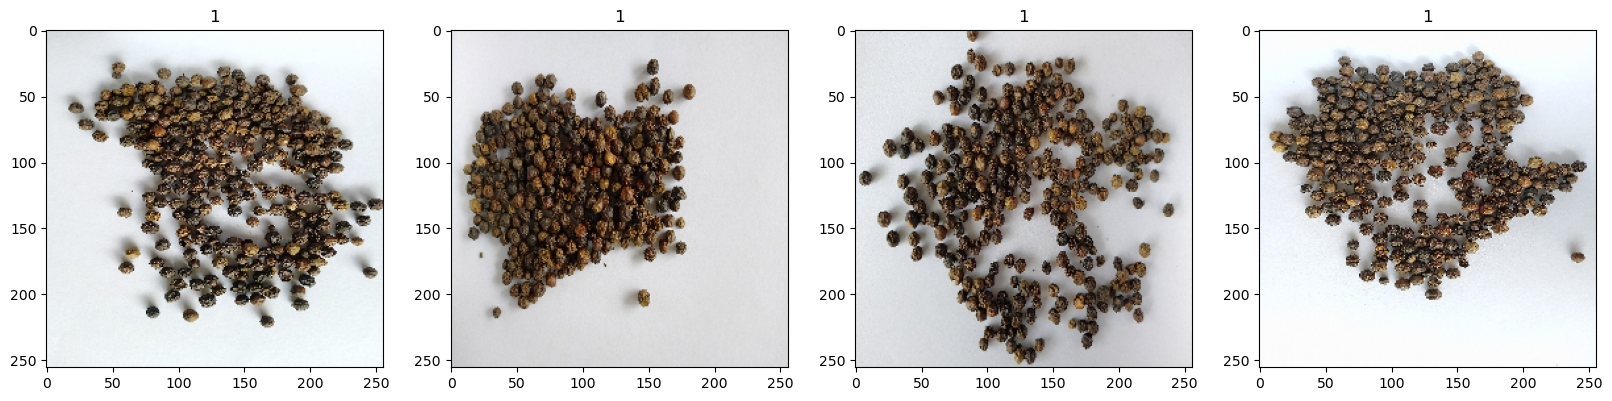

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
data = data.map(lambda x, y: (x / 255, y))
data = data.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

In [7]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [8]:
train_size

37

In [9]:
val_size

4

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [12]:
train = train.map(augment_image)

In [13]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
model = Sequential()

In [15]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [18]:
logdir='logs'

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/50


37/37 [==============================] - 168s 4s/step - loss: 3.9751 - accuracy: 0.7492 - val_loss: 0.2803 - val_accuracy: 0.9609
Epoch 2/50
37/37 [==============================] - 122s 3s/step - loss: 0.2906 - accuracy: 0.9527 - val_loss: 0.1999 - val_accuracy: 0.9766
Epoch 3/50
37/37 [==============================] - 121s 3s/step - loss: 0.2585 - accuracy: 0.9544 - val_loss: 0.1823 - val_accuracy: 0.9922
Epoch 4/50
37/37 [==============================] - 124s 3s/step - loss: 0.2132 - accuracy: 0.9704 - val_loss: 0.1469 - val_accuracy: 0.9844
Epoch 5/50
37/37 [==============================] - 123s 3s/step - loss: 0.1802 - accuracy: 0.9755 - val_loss: 0.1266 - val_accuracy: 0.9922
Epoch 6/50
37/37 [==============================] - 127s 3s/step - loss: 0.1722 - accuracy: 0.9738 - val_loss: 0.1203 - val_accuracy: 1.0000
Epoch 7/50
37/37 [==============================] - 124s 3s/step - loss: 0.1817 - accuracy: 0.9721 - val_loss: 0.1185 - val_accuracy: 1.0000
Epoch 8/50


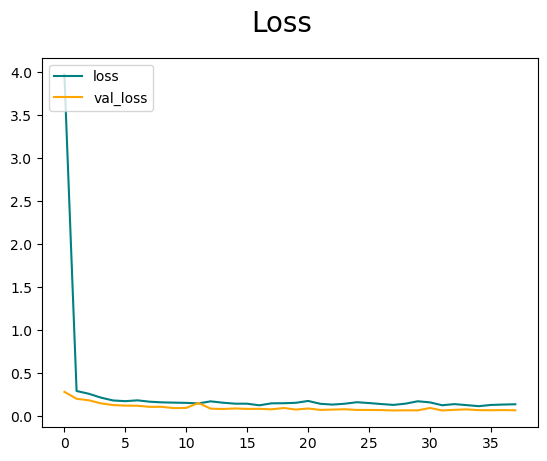

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

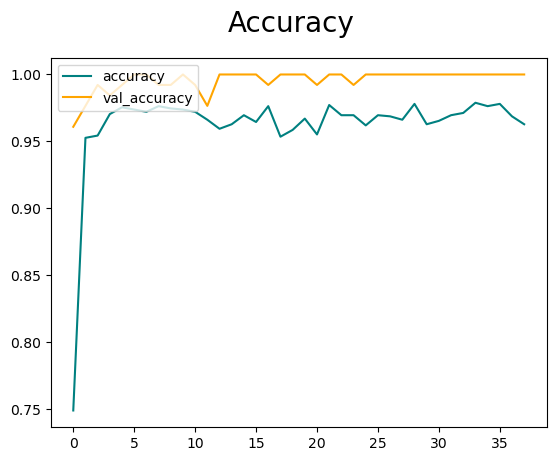

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc

In [24]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [25]:
true_labels = []
predicted_labels = []

In [26]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    true_labels.extend(y)
    predicted_labels.extend(yhat)

1/1 [==============================] - 2s 2s/step


In [27]:
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
f1 = 2 * (precision * recall) / (precision + recall)

In [28]:
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Precision: 1.0
Recall: 1.0
Accuracy: 1.0
F1 Score: 1.0


In [29]:
true_labels = np.array(true_labels)
predicted_labels = (np.array(predicted_labels) > 0.5).astype(int)

In [30]:
cm = confusion_matrix(predicted_labels, true_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[68  0]
 [ 0 60]]


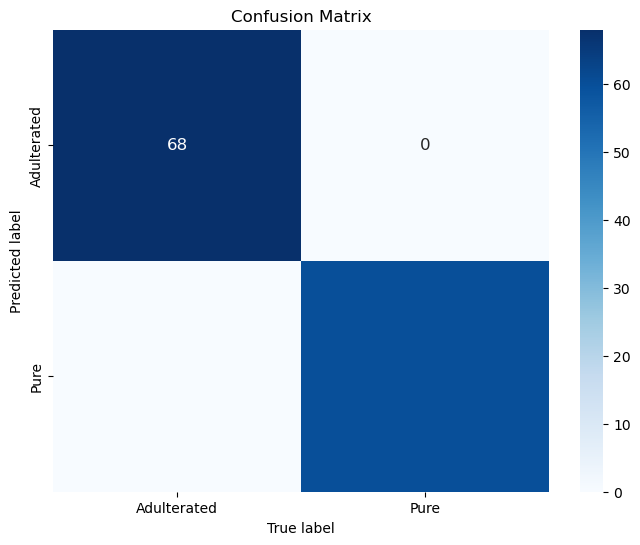

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'],
            annot_kws={"fontsize": 12})  # Increase the fontsize
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [32]:
report = classification_report(true_labels, predicted_labels, target_names=['Adulterated', 'Pure'], digits=4)
print(report)

              precision    recall  f1-score   support

 Adulterated     1.0000    1.0000    1.0000        68
        Pure     1.0000    1.0000    1.0000        60

    accuracy                         1.0000       128
   macro avg     1.0000    1.0000    1.0000       128
weighted avg     1.0000    1.0000    1.0000       128



Area Under Curve (AUC): 1.0


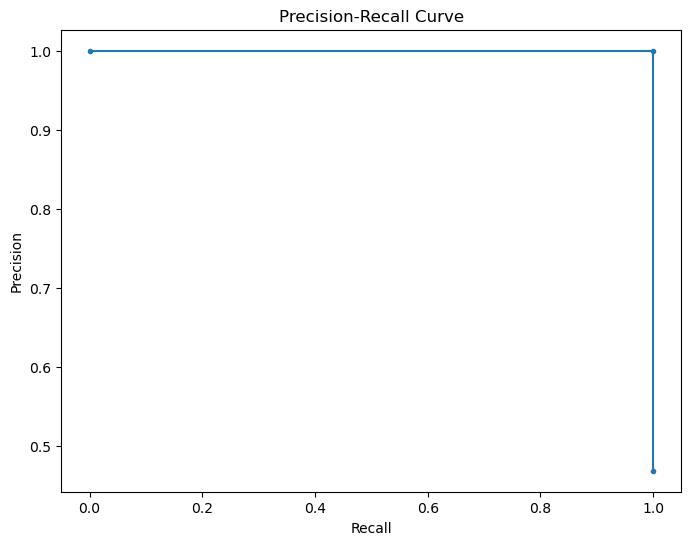

In [33]:
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)
area_under_curve = auc(recall, precision)

print("Area Under Curve (AUC):", area_under_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

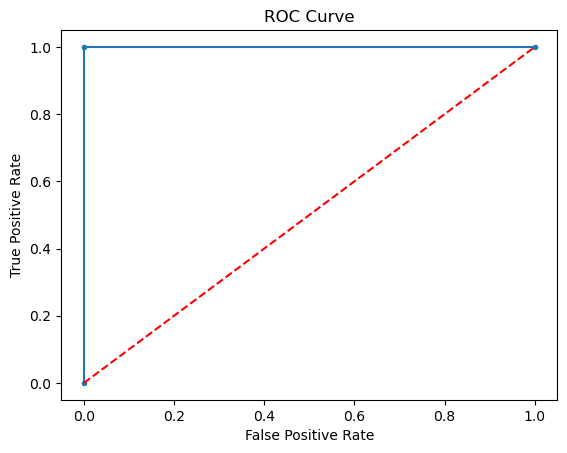

FPR: 0.0, TPR: 0.0
FPR: 0.0, TPR: 1.0
FPR: 1.0, TPR: 1.0


In [34]:
from sklearn.metrics import roc_curve
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

# Plot ROC curve
ax.plot(fpr, tpr, marker='.')
ax.plot([0, 1], [0, 1], linestyle='--', color='red')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

# Show the plot
plt.show()
for i in range(len(fpr)):
    print(f"FPR: {fpr[i]}, TPR: {tpr[i]}")

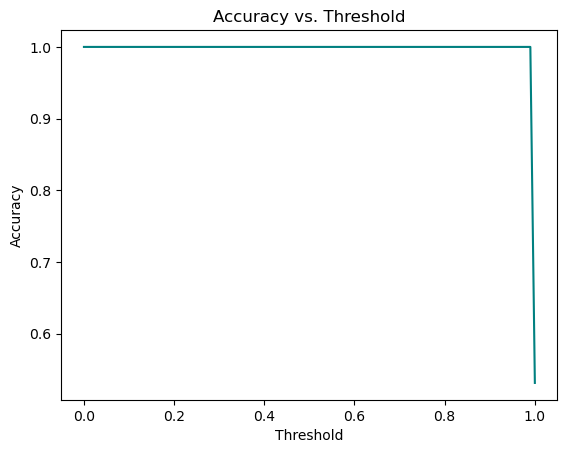

Threshold: 0.00, Accuracy: 1.0000
Threshold: 0.01, Accuracy: 1.0000
Threshold: 0.02, Accuracy: 1.0000
Threshold: 0.03, Accuracy: 1.0000
Threshold: 0.04, Accuracy: 1.0000
Threshold: 0.05, Accuracy: 1.0000
Threshold: 0.06, Accuracy: 1.0000
Threshold: 0.07, Accuracy: 1.0000
Threshold: 0.08, Accuracy: 1.0000
Threshold: 0.09, Accuracy: 1.0000
Threshold: 0.10, Accuracy: 1.0000
Threshold: 0.11, Accuracy: 1.0000
Threshold: 0.12, Accuracy: 1.0000
Threshold: 0.13, Accuracy: 1.0000
Threshold: 0.14, Accuracy: 1.0000
Threshold: 0.15, Accuracy: 1.0000
Threshold: 0.16, Accuracy: 1.0000
Threshold: 0.17, Accuracy: 1.0000
Threshold: 0.18, Accuracy: 1.0000
Threshold: 0.19, Accuracy: 1.0000
Threshold: 0.20, Accuracy: 1.0000
Threshold: 0.21, Accuracy: 1.0000
Threshold: 0.22, Accuracy: 1.0000
Threshold: 0.23, Accuracy: 1.0000
Threshold: 0.24, Accuracy: 1.0000
Threshold: 0.25, Accuracy: 1.0000
Threshold: 0.26, Accuracy: 1.0000
Threshold: 0.27, Accuracy: 1.0000
Threshold: 0.28, Accuracy: 1.0000
Threshold: 0.2

In [35]:
thresholds = np.arange(0, 1.01, 0.01)
predicted_labels = np.array(predicted_labels)
accuracies = [np.mean((predicted_labels.ravel().astype(bool) > threshold) == true_labels) for threshold in thresholds]
plt.plot(thresholds, accuracies, color='teal')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.show()
for threshold, accuracy in zip(thresholds, accuracies):
    print(f'Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}')

In [36]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [37]:
import cv2

1/1 [==============================] - 3s 3s/step
[[3.2032605e-07]]
Predicted class is Adulterated with confidence level 100.00


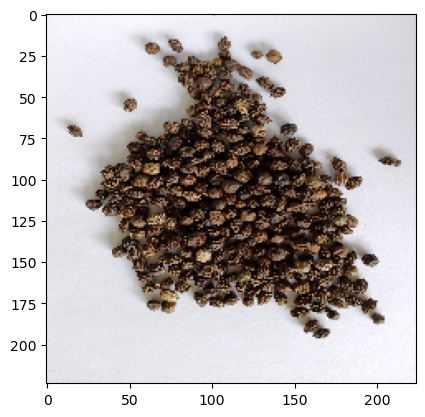

In [38]:
img = cv2.imread('new/Adulterated/A (8).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
resize = tf.image.resize(img, (224,224))


# Predict the class probabilities
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

# Get the predicted class and confidence level
threshold = 0.5
predicted_class = 'Pure' if yhat[0] > threshold else 'Adulterated'
confidence_level = (yhat[0][0] - 0.5) * 2 * 100 if yhat[0] > threshold else (0.5 - yhat[0][0]) * 2 * 100
print(f'Predicted class is {predicted_class} with confidence level {confidence_level:.2f}')

plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save(os.path.join('new\models','densenet121.h5'))

C:\Users\rebab\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
loaded_model = load_model('new\models\densenet121.h5')

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()
with open('new\DenseNet121.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmp944xz4yc\assets


INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmp944xz4yc\assets
